In [1]:
import os
import time
import argparse
import random
# from abc import ABC

import cv2
import numpy as np
import torch
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from matplotlib import cm

from scipy.ndimage import label
import numpy as np

import lightning as L
from lightning.fabric.loggers import TensorBoardLogger
from lightning.fabric.fabric import _FabricOptimizer

import torchvision
from box import Box
from datasets import call_load_dataset
from utils.model import Model
from utils.losses import DiceLoss, FocalLoss, Matching_Loss
from utils.eval_utils import AverageMeter, validate, get_prompts, calc_iou, validate_sam2
from utils.tools import copy_model, create_csv, reduce_instances
from utils.utils import *

import  csv, copy
import torch
import torch.nn.functional as F
from collections import deque

/home/tic/miniconda3/envs/cvpr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
    

# %% [markdown]
# ## Optimizer and Scheduler Configuration

# %% [code]
def configure_opt(cfg: Box, model: Model):
    def lr_lambda(step):
        if step < cfg.opt.warmup_steps:
            return step / cfg.opt.warmup_steps
        elif step < cfg.opt.steps[0]:
            return 1.0
        elif step < cfg.opt.steps[1]:
            return 1 / cfg.opt.decay_factor
        else:
            return 1 / (cfg.opt.decay_factor**2)

    optimizer = torch.optim.Adam(model.model.parameters(),
                                 lr=cfg.opt.learning_rate,
                                 weight_decay=cfg.opt.weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return optimizer, scheduler





In [3]:
def process_forward(img_tensor, prompt, model):
    with torch.no_grad():
        _, logits, _, _ = model(img_tensor, prompt)

    masks_pred = torch.sigmoid(torch.stack(logits, dim=0))
    entropy_maps = []
    eps = 1e-8
    for mask_p in masks_pred[0]:  # or just masks_pred if it's already a list
        # Entropy per pixel
        entropy = - (mask_p * torch.log(mask_p + eps) + (1 - mask_p) * torch.log(1 - mask_p + eps))
    
  
        max_ent = torch.log(torch.tensor(2.0, device=mask_p.device))
        entropy_norm = entropy / (max_ent + 1e-8)   # [0, 1]
                
        entropy_maps.append(entropy_norm)

    return entropy_maps, masks_pred
        

In [4]:
def entropy_map_calculate(p):
    eps = 1e-8
    p = p.clamp(eps, 1 - eps)  # Safe!
    entropy_map = - (p * torch.log(p) + (1 - p) * torch.log(1 - p))
    # entropy_map = entropy_map.max(dim=0)[0]
    return entropy_map# / torch.log(torch.tensor(2.0))

In [5]:
def get_bbox_feature(embedding_map, bbox, stride=16, pooling='avg'):
    """
    Extract a feature vector from an embedding map given a bounding box.
    
    Args:
        embedding_map (torch.Tensor): Shape (C, H_feat, W_feat) or (B, C, H_feat, W_feat)
        bbox (list or torch.Tensor): [x1, y1, x2, y2] in original image coordinates
        stride (int): Downscaling factor between image and feature map
        pooling (str): 'avg' or 'max' pooling inside the bbox region
        
    Returns:
        torch.Tensor: Feature vector of shape (C,)
    """
    # If batch dimension exists, assume batch size 1
    if embedding_map.dim() == 4:
        embedding_map = embedding_map[0]

    C, H_feat, W_feat = embedding_map.shape
    x1, y1, x2, y2 = bbox

    # Map bbox to feature map coordinates
    fx1 = max(int(x1 / stride), 0)
    fy1 = max(int(y1 / stride), 0)
    fx2 = min(int((x2 + stride - 1) / stride), W_feat)  # ceil division
    fy2 = min(int((y2 + stride - 1) / stride), H_feat)

    # Crop the feature map to bbox region
    region = embedding_map[:, fy1:fy2, fx1:fx2]

    if region.numel() == 0:
        # fallback to global feature if bbox is too small
        region = embedding_map

    # Pool to get a single feature vector
    if pooling == 'avg':
        feature_vec = region.mean(dim=(1,2))
    elif pooling == 'max':
        feature_vec = region.amax(dim=(1,2))
    else:
        raise ValueError("pooling must be 'avg' or 'max'")

    return feature_vec

In [6]:
def configure_opt(cfg: Box, model: Model):

    def lr_lambda(step):
        if step < cfg.opt.warmup_steps:
            return step / cfg.opt.warmup_steps
        elif step < cfg.opt.steps[0]:
            return 1.0
        elif step < cfg.opt.steps[1]:
            return 1 / cfg.opt.decay_factor
        else:
            return 1 / (cfg.opt.decay_factor**2)

    # optimize only trainable params (e.g., LoRA)
    trainable_params = (p for p in model.model.parameters() if p.requires_grad)
    optimizer = torch.optim.Adam(trainable_params, lr=cfg.opt.learning_rate, weight_decay=cfg.opt.weight_decay)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    return optimizer, scheduler

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms.functional as TF
import cv2
from matplotlib.patches import Rectangle

def visualize_instance_segmentation(images_weak, gt_masks_new,prompts, entropy_maps, preds,
                                    invert_overlap_map, soft_masks, bboxes, j=0, slice_step=50):
    """
    Visualizes:
    1. The weak input image
    2. Ground-truth instance masks
    3. Entropy heatmaps
    4. Predicted masks
    5. Bounding boxes overlaid on image
    """

    # --- Convert image tensor to numpy
    img = images_weak[0].detach().cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    if img.min() < 0:
        img = img * std + mean
    img_np = TF.to_pil_image(img.clamp(0, 1))
    img_np = np.array(img_np)

    # --- Shapes
    num_instances = gt_masks_new.shape[1]
    H, W = gt_masks_new.shape[-2:]
    print(f"🔹 Visualizing {num_instances} instances, each {H}×{W}")

    # --- Convert tensors to numpy
    gt_masks_np = gt_masks_new[0].detach().cpu().numpy()
    entropy_maps_np = entropy_maps[0].detach().cpu().numpy()
    preds_np = preds.detach().cpu().numpy()[0]
    print(preds_np.min())
   

        # --- Plot image with bounding boxes AND prompt points
    print("Original Image with Bounding Boxes and Prompt Points")
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_np)

    # Draw bounding boxes
    if bboxes.max() <= 1.5:
        bboxes_scaled = bboxes.clone()
        bboxes_scaled[:, [0, 2]] *= W
        bboxes_scaled[:, [1, 3]] *= H
    else:
        bboxes_scaled = bboxes

    for idx, box in enumerate(bboxes_scaled):
        x1, y1, x2, y2 = box.tolist()
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height,
                         linewidth=2, edgecolor='lime', facecolor='none',
                         label='BBox' if idx == 0 else "")
        ax.add_patch(rect)

    # === PLOT PROMPT POINTS ===
    try:
        point_coords = prompts[0][0].detach().cpu().numpy()  # [N, 2]
        point_labels = prompts[0][1].detach().cpu().numpy()  # [N,]

        # Scale coordinates if normalized
        if point_coords.max() <= 1.5:
            point_coords_px = point_coords.copy()
            point_coords_px[:, 0] *= W
            point_coords_px[:, 1] *= H
        else:
            point_coords_px = point_coords

        pos_points = point_coords_px[point_labels == 1]
        neg_points = point_coords_px[point_labels == 0]

        if len(pos_points) > 0:
            ax.scatter(pos_points[:, 0], pos_points[:, 1], c='green', s=80, marker='o',
                       edgecolors='white', linewidths=1.5, label='Positive Prompt', zorder=5)
        if len(neg_points) > 0:
            ax.scatter(neg_points[:, 0], neg_points[:, 1], c='red', s=80, marker='x',
                       linewidths=3, label='Negative Prompt', zorder=5)

    except Exception as e:
        print(f"Could not plot prompts: {e}")

    ax.set_title(f"Image + BBoxes + Prompts (Inst: {num_instances})")
    ax.axis('off')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, loc='upper right')
    plt.tight_layout()
    plt.show()

    # --- Visualize per-instance details
    n_cols = 4
    n_rows = min(num_instances, 5)
    for i in range(n_rows):
        gt_mask = gt_masks_np[i]
        gt_colored = img_np.copy()
        gt_mask_rgb = cv2.applyColorMap((gt_mask * 255).astype(np.uint8), cv2.COLORMAP_JET)
        gt_mask_rgb = cv2.cvtColor(gt_mask_rgb, cv2.COLOR_BGR2RGB)
        gt_overlay = cv2.addWeighted(gt_mask_rgb, 0.5, gt_colored, 0.5, 0)

        entropy = entropy_maps_np[i]
        entropy_norm = (entropy - entropy.min()) / (entropy.max() - entropy.min() + 1e-8)
        entropy_heatmap = cv2.applyColorMap((entropy_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)
        entropy_heatmap = cv2.cvtColor(entropy_heatmap, cv2.COLOR_BGR2RGB)

        pred_mask = preds_np[i]
        pred_colored = img_np.copy()
        pred_mask_rgb = cv2.applyColorMap((pred_mask * 255).astype(np.uint8), cv2.COLORMAP_PARULA)
        pred_mask_rgb = cv2.cvtColor(pred_mask_rgb, cv2.COLOR_BGR2RGB)
        pred_overlay = cv2.addWeighted(pred_mask_rgb, 0.5, pred_colored, 0.5, 0)

        print(f"Instance {i+1} GT mask")
        plt.imshow(gt_mask, cmap='gray')
        plt.show()

        print(f"Instance {i+1} Entropy")
        plt.imshow(entropy_norm, cmap='viridis')
        plt.show()

        print(f"Instance {i+1} Predicted mask")
        plt.imshow(pred_mask > 0.95, cmap='gray')
        plt.show()

    print("Inverted overlap")
    plt.imshow(invert_overlap_map.detach().cpu().numpy(), cmap='viridis')
    plt.show()

    pred_one = (preds_np > 0.5).sum(axis=0)
    print("Pred all")
    plt.imshow(pred_one > 0.5, cmap='gray')
    plt.show()
    
    print("Pseudo labels")

 
  
    pseudo_lab = torch.sigmoid(torch.stack(soft_masks, dim=0)).sum(dim=1)
    print(pseudo_lab.shape)
    print(pseudo_lab.max())
    plt.imshow((pseudo_lab[0].detach().cpu().numpy() > 0.5), cmap='gray')
    plt.show()

    print("Bounding boxes tensor:", bboxes.shape)


In [9]:
def train_sam(
    cfg: Box,
    fabric: L.Fabric,
    model: Model,
    optimizer: _FabricOptimizer,
    scheduler: _FabricOptimizer,
    train_dataloader: DataLoader,
    val_dataloader: DataLoader,
    init_iou, 
    vis
):

    focal_loss = FocalLoss()
    dice_loss = DiceLoss()
    best_iou = init_iou
    best_state = copy.deepcopy(model.state_dict())
    no_improve_count = 0
    max_patience = cfg.get("patience", 3)  # stop if no improvement for X validations
    match_interval = cfg.match_interval
    eval_interval = int(len(train_dataloader) * 1)

    window_size = 100
    embedding_queue = []
    ite_em = 0

    # Prepare output dirs
    os.makedirs(os.path.join(cfg.out_dir, "save"), exist_ok=True)
    csv_path = os.path.join(cfg.out_dir, "training_log.csv")

    # Initialize CSV
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "Iteration", "Val_IoU", "Best_IoU", "Status"])

    fabric.print(f"Training with rollback enabled. Logging to: {csv_path}")


    for epoch in range(1, cfg.num_epochs + 1):
        batch_time = AverageMeter()
        data_time = AverageMeter()
        focal_losses = AverageMeter()
        dice_losses = AverageMeter()
        iou_losses = AverageMeter()
        total_losses = AverageMeter()
        sim_losses = AverageMeter()
        end = time.time()
        x = random.randint(0, len(train_dataloader))
        print(x)

        for iter, data in enumerate(train_dataloader):

            data_time.update(time.time() - end)
            images_weak, images_strong, bboxes_gt, gt_masks, img_paths= data
            del data

            

            if iter==x:
                slice_step = 50
                for j in range(0, len(gt_masks[0]), slice_step):
                 
                    
                    gt_masks_new = gt_masks[0][j:j+slice_step].unsqueeze(0)
                    prompts = get_prompts(cfg, bboxes_gt, gt_masks_new)
    
                    batch_size = images_weak.size(0)
    
    
                    entropy_maps, preds = process_forward(images_weak, prompts, model)
                    entropy_maps = torch.stack(entropy_maps, dim=0).unsqueeze(0)
    
    
                    pred_binary = ((preds[0]* (1-entropy_maps[0])) >0.95).float() #* (1-entropy_maps[0]) #(pred_stack>0.95 ) & 
    
                    
                    
    
                    overlap_count = pred_binary.sum(dim=0)  
                    overlap_map = (overlap_count > 1).float()
                    invert_overlap_map = 1.0 - overlap_map

                    
                 
                    bboxes = []
                    point_list = []
                    point_labels_list = []
    
                   
                    for i,  pred in enumerate( preds[0]):
                        point_coords = prompts[0][0][i][:].unsqueeze(0)
                        point_coords_lab = prompts[0][1][i][:].unsqueeze(0)
                      
                        pred_without_overlap = (pred) * invert_overlap_map
                  
                        
                        
                        ys, xs = torch.where(pred_without_overlap> 0.5)
                        if len(xs) > 0 and len(ys) > 0:
                            x_min, x_max = xs.min().item(), xs.max().item()
                            y_min, y_max = ys.min().item(), ys.max().item()
                            bboxes.append(torch.tensor([x_min, y_min , x_max, y_max], dtype=torch.float32))
    
                            point_list.append(point_coords)
                            point_labels_list.append(point_coords_lab)
                    
                    if len(bboxes) == 0:
                        continue  # skip if no valid region
                   
                            
                    point_ = torch.cat(point_list).squeeze(1)
                    point_labels_ = torch.cat(point_labels_list)
                    new_prompts = [(point_, point_labels_)]
                
                    bboxes = torch.stack(bboxes)

                    
    
                    with torch.no_grad():
                        embeddings, soft_masks, _, _ = model(images_weak, bboxes.unsqueeze(0))
                        
      
                    _, pred_masks, iou_predictions, _= model(images_strong, new_prompts)
                    del _
               

                    # print(preds[0].shape)
                    # print(soft_masks[0].shape)
                     # Visualization
                    visualize_instance_segmentation(images_weak, gt_masks_new, prompts, entropy_maps, preds, invert_overlap_map, soft_masks, bboxes)
    
                    num_masks = sum(len(pred_mask) for pred_mask in pred_masks)
                    loss_focal = torch.tensor(0., device=fabric.device)
                    loss_dice = torch.tensor(0., device=fabric.device)
                    loss_iou = torch.tensor(0., device=fabric.device)
                    loss_sim = torch.tensor(0., device=fabric.device)
    
                    
    
                    for i, (pred_mask, soft_mask, iou_prediction, bbox) in enumerate(
                            zip(pred_masks, soft_masks, iou_predictions, bboxes  )
                        ):  
    
                            embed_feats = get_bbox_feature( embeddings, bbox)
                            embed_feats = F.normalize(embed_feats, p=2, dim=0)
                            embedding_queue.append(embed_feats)
                            loss_match = 0
                            
                           
                            if len(embedding_queue) > 1:
                                # Stack all embeddings (num_instances, feature_dim)
                                features = torch.stack(embedding_queue, dim=0)  # [N, D]
                                eps = 1e-8
    
                                # Compute cosine similarity matrix
                                cos_sim_matrix = F.cosine_similarity(
                                    features.unsqueeze(1),  # [N, 1, D]
                                    features.unsqueeze(0),  # [1, N, D]
                                    dim=2,
                                    eps=eps
                                )  # shape [N, N]
    
                                # Remove self-similarity bias
                                num = features.size(0)
                                mask = (1 - torch.eye(num, device=features.device))
                                cos_sim_matrix = cos_sim_matrix * mask
    
                                # ---- Soft alignment (SSAL) ----
                                # Step 1. Rescale cosine to [0,1]
                                cos_sim_matrix = (cos_sim_matrix + 1) / 2
    
                                # Step 2. Compute temperature-scaled soft distribution
                                tau = 0.07  # you can tune in [0.03–0.1]
                                sim_soft = torch.exp(cos_sim_matrix / tau)
                                prob_matrix = sim_soft / (sim_soft.sum(dim=1, keepdim=True) + eps)
    
                                # Step 3. Soft Semantic Alignment Loss
                                loss_sim = ((1 - cos_sim_matrix) * prob_matrix).sum(dim=1).mean()
    
                            else:
                                loss_sim = torch.tensor(0.0, device=embeddings.device)
    
                            soft_mask = (soft_mask > 0).float()
                            # print(soft_mask.mean(), gt_masks_new[i].mean())
    
                            # Apply entropy mask to losses
                            loss_focal += focal_loss(pred_mask, soft_mask)  #, entropy_mask=entropy_mask
                            loss_dice += dice_loss(pred_mask, soft_mask)   #, entropy_mask=entropy_mask
                            batch_iou = calc_iou(pred_mask, soft_mask)
                            loss_iou += F.mse_loss(iou_prediction, batch_iou, reduction='sum') / num_masks
    
                            if len(embedding_queue) > window_size:
                                embedding_queue.pop(0)
                
                    del  pred_masks, iou_predictions, entropy_maps, preds
                
                    loss_total =  20 * loss_focal +  loss_dice  + loss_iou + 0.1*loss_sim #+ loss_iou  +  +
                    torch.cuda.empty_cache()
                    
                break 
    
                    
    
                #     fabric.backward(loss_total)
    
                #     optimizer.step()
                #     scheduler.step()
                #     optimizer.zero_grad()
                #     torch.cuda.empty_cache()
                #     del  prompts, soft_masks
    
                #     batch_time.update(time.time() - end)
                #     end = time.time()
    
                #     focal_losses.update(loss_focal.item(), batch_size)
                #     dice_losses.update(loss_dice.item(), batch_size)
                #     iou_losses.update(loss_iou.item(), batch_size)
                #     total_losses.update(loss_total.item(), batch_size)
                #     sim_losses.update(loss_sim.item(), batch_size)
                
                #     del loss_dice, loss_iou, loss_focal
    
                # if (iter+1) % match_interval==0:
                #     fabric.print(
                #         f"Epoch [{epoch}] Iter [{iter + 1}/{len(train_dataloader)}] "
                #         f"| Focal {focal_losses.avg:.4f} | Dice {dice_losses.avg:.4f} | "
                #         f"IoU {iou_losses.avg:.4f} | Sim_loss {sim_losses.avg:.4f} | Total {total_losses.avg:.4f}"
                #     )
                # if (iter+1) % 700 == 0:
                #     val_iou, _ = validate(fabric, cfg, model, val_dataloader, cfg.name, epoch)
    
                #     status = ""
                #     if val_iou > best_iou:  #best_iou
                #         best_iou = val_iou
                #         best_state = copy.deepcopy(model.state_dict())
                #         torch.save(best_state, os.path.join(cfg.out_dir, "save", "best_model.pth"))
                #         status = "Improved → Model Saved"
                #         no_improve_count = 0
                #     else:
                #         model.load_state_dict(best_state)
                #         no_improve_count += 1
                #         status = f"Rollback ({no_improve_count})"
    
                #     # Write log entry
                #     with open(csv_path, "a", newline="") as f:
                #         writer = csv.writer(f)
                #         writer.writerow([epoch, iter + 1, val_iou, best_iou, status])
    
                #     fabric.print(f"Validation IoU={val_iou:.4f} | Best={best_iou:.4f} | {status}")
    
                #     # Stop if model fails to stabilize
                #     if no_improve_count >= max_patience:
                #         fabric.print(f"Training stopped early after {no_improve_count} failed rollbacks.")
                #         return
            

In [10]:
# %% [markdown]
# ## Configuration Loading and Launch

# %% [code]
# Example: set arguments manually here
# Replace with your config module path, e.g. "configs.default_config"
import importlib

CFG_MODULE = "configs.config_nwpu"
cfg_module = importlib.import_module(CFG_MODULE)
cfg = cfg_module.cfg

# Manually merge updates if needed
cfg.out_dir = "./outputs"
cfg.resume = False

torch.cuda.empty_cache()
torch.set_float32_matmul_precision('high')

# main(cfg)

In [11]:
gpu_ids = [str(i) for i in range(torch.cuda.device_count())]
num_devices = len(gpu_ids)
fabric = L.Fabric(accelerator="auto",
                  devices=num_devices,
                  strategy="auto",
                  loggers=[TensorBoardLogger(cfg.out_dir)])
fabric.launch()
fabric.seed_everything(1337 + fabric.global_rank)

if fabric.global_rank == 0:
    os.makedirs(os.path.join(cfg.out_dir, "save"), exist_ok=True)
    create_csv(os.path.join(cfg.out_dir, "metrics.csv"), csv_head=cfg.csv_keys)

with fabric.device:
    model = Model(cfg)
    model.setup()
    

load_datasets = call_load_dataset(cfg)
train_data, val_data, pt_data = load_datasets(cfg, img_size=1024, return_pt = True)
train_data = fabric._setup_dataloader(train_data)
val_data = fabric._setup_dataloader(val_data)
pt_data = fabric._setup_dataloader(pt_data)
optimizer, scheduler = configure_opt(cfg, model)
model, optimizer = fabric.setup(model, optimizer)



auto_ckpt = None


if auto_ckpt is not None:
    full_checkpoint = fabric.load(auto_ckpt)

    if isinstance(full_checkpoint, dict) and "model" in full_checkpoint:
        model.load_state_dict(full_checkpoint["model"])
        if "optimizer" in full_checkpoint:
            optimizer.load_state_dict(full_checkpoint["optimizer"])
    else:
        model.load_state_dict(full_checkpoint)
    loaded = True
    fabric.print(f"Resumed from explicit checkpoint: {cfg.model.ckpt}")
    # state = torch.load(auto_ckpt, map_location=fabric.device)
    # if isinstance(state, dict) and "model" in state:
    #     model.load_state_dict(state["model"])
    #     if "optimizer" in state:
    #         optimizer.load_state_dict(state["optimizer"])
    # else:
    #     model.load_state_dict(state)
    # fabric.print(f"Auto-resumed from: {auto_ckpt}")
init_iou = 0.67
# print('-'*100)
# print('\033[92mDirect test on the original SAM.\033[0m') 
# init_iou, _, = validate(fabric, cfg, model, val_data, name=cfg.name, epoch=0)
# print('-'*100)
# del _     








Global seed set to 1337


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!


Training with rollback enabled. Logging to: ./outputs/training_log.csv
374
🔹 Visualizing 5 instances, each 1024×1024
2.9925543e-36
Original Image with Bounding Boxes and Prompt Points


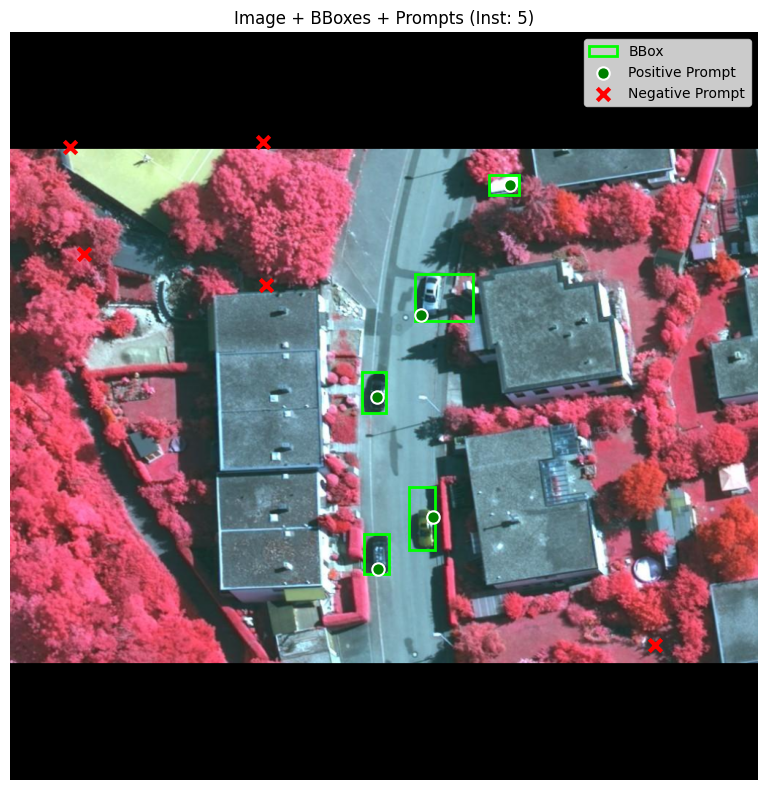

Instance 1 GT mask


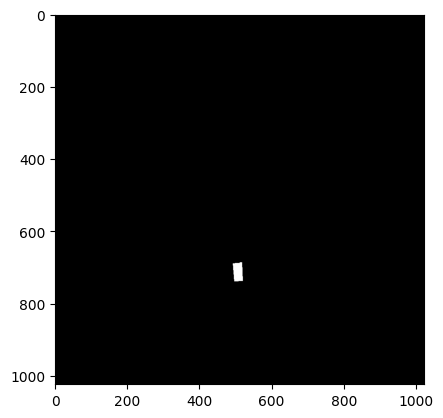

Instance 1 Entropy


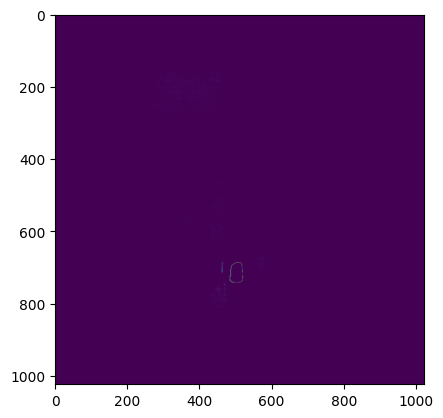

Instance 1 Predicted mask


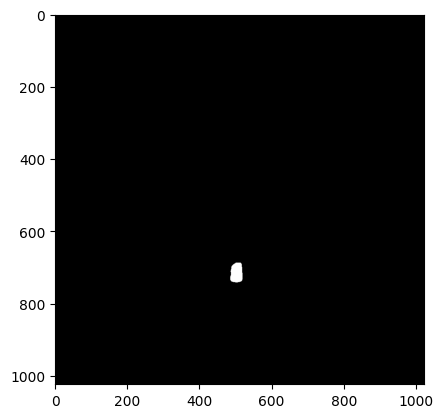

Instance 2 GT mask


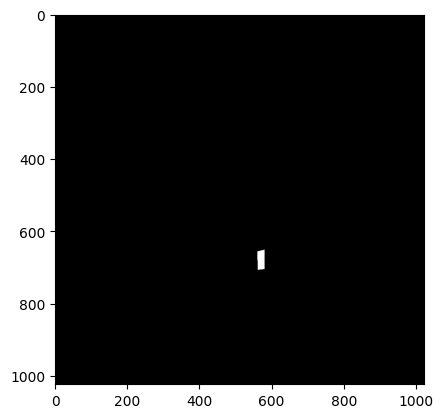

Instance 2 Entropy


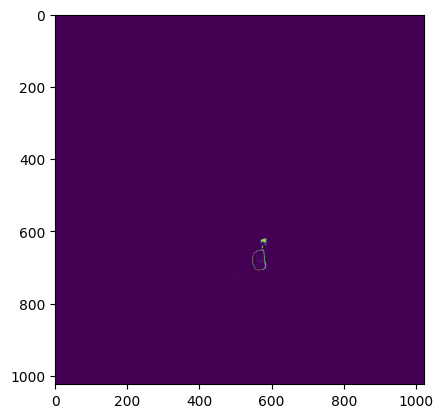

Instance 2 Predicted mask


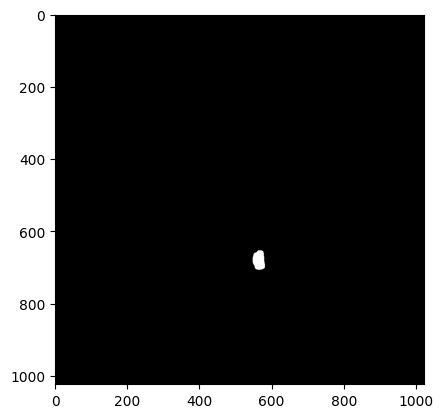

Instance 3 GT mask


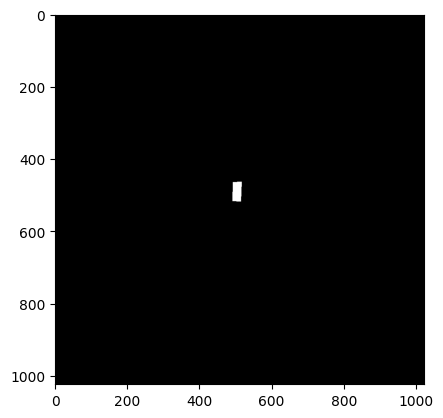

Instance 3 Entropy


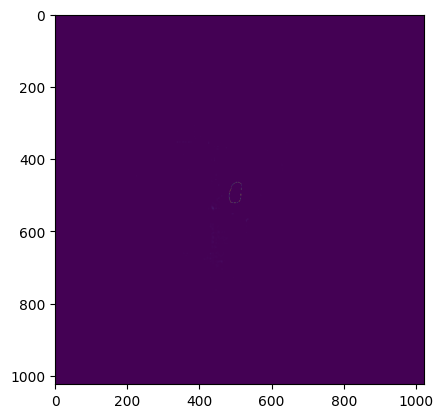

Instance 3 Predicted mask


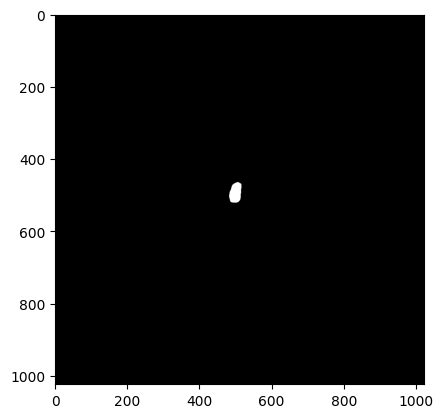

Instance 4 GT mask


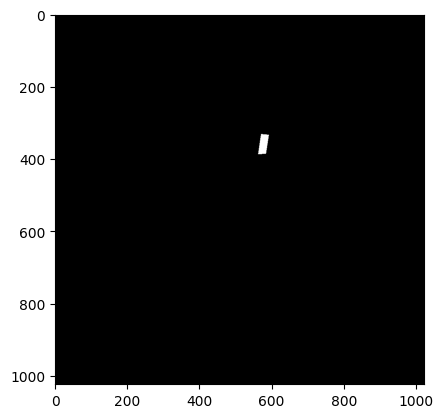

Instance 4 Entropy


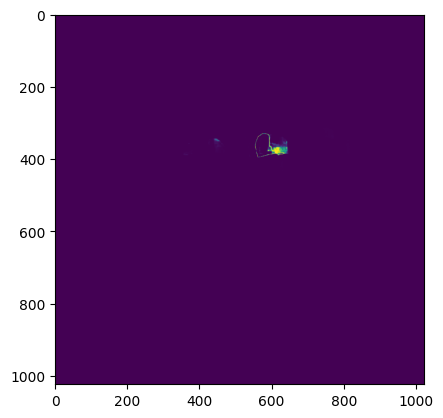

Instance 4 Predicted mask


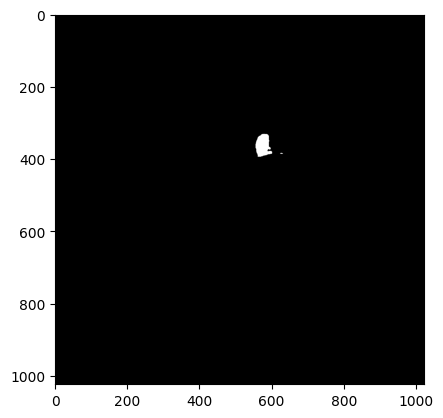

Instance 5 GT mask


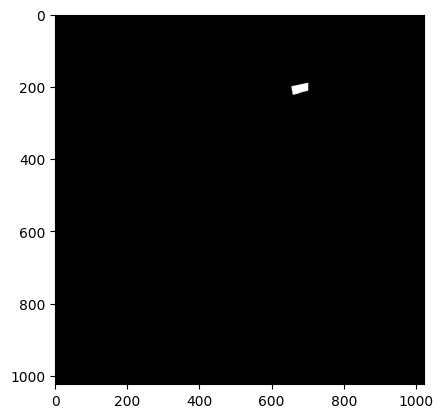

Instance 5 Entropy


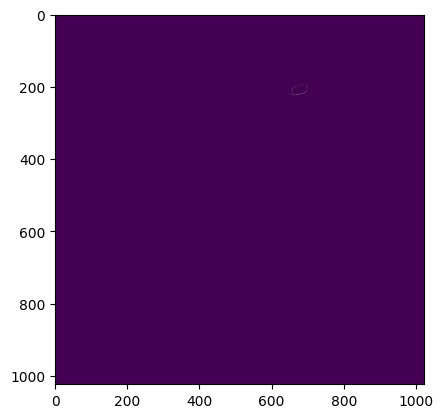

Instance 5 Predicted mask


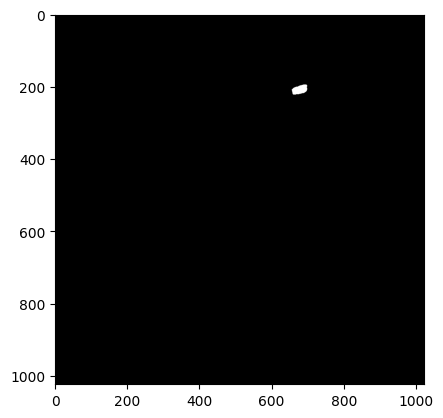

Inverted overlap


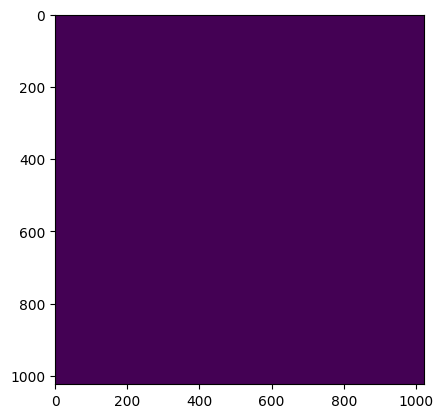

Pred all


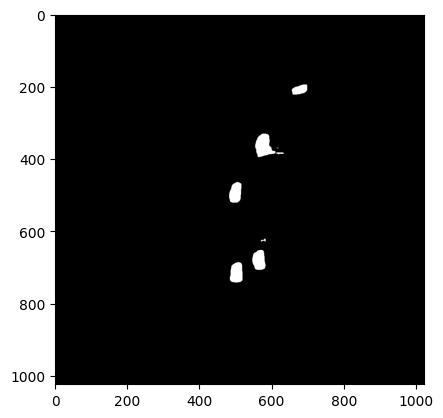

Pseudo labels
torch.Size([1, 1024, 1024])
tensor(1.0001, device='cuda:0')


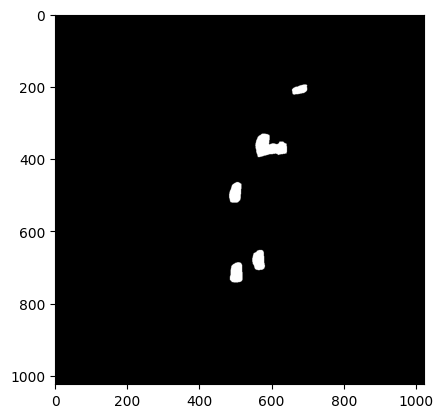

Bounding boxes tensor: torch.Size([5, 4])
84


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 0 has a total capacity of 5.68 GiB of which 382.88 MiB is free. Process 2768 has 6.28 MiB memory in use. Including non-PyTorch memory, this process has 5.28 GiB memory in use. Of the allocated memory 4.67 GiB is allocated by PyTorch, and 484.28 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [12]:
train_sam(cfg, fabric, model, optimizer, scheduler, train_data, val_data, init_iou, True)



In [128]:
for iter, data in enumerate(train_data):
    images_weak, images_strong, bboxes, gt_masks, img_paths= data
    print(bboxes)
    if iter>2:
        break
      

(tensor([[ 62.9978, 156.2468, 146.6130, 251.3434],
        [408.9128, 682.1429, 492.5280, 773.8023],
        [497.1096, 626.0014, 553.2349, 686.7258],
        [326.4430, 718.8066, 384.8591, 786.4055],
        [802.9351, 800.1544, 883.1141, 862.0245],
        [878.5324, 744.0130, 952.9843, 804.7374]], device='cuda:0',
       dtype=torch.float64),)
(tensor([[205.0304, 403.1925, 620.8504, 556.3290]], device='cuda:0',
       dtype=torch.float64),)
(tensor([[280.8439, 395.4326, 622.1772, 513.1195],
        [278.6835, 319.8539, 357.5359, 379.2372],
        [ 50.7679, 380.3169, 149.0633, 441.8596],
        [629.7384, 273.4269, 729.1139, 341.4478],
        [772.3207, 429.9829, 858.7342, 486.1271]], device='cuda:0',
       dtype=torch.float64),)
(tensor([[465.7175, 461.3976, 626.2599, 569.8313]], device='cuda:0',
       dtype=torch.float64),)


In [5]:
# _, _, = validate(fabric, cfg, model, val_data, name=cfg.name, epoch=0)

In [5]:
def prompt_calibration(cfg, entrop_map, prompts, point_status):
    point_list = []
    point_labels_list = []
    num_points = cfg.num_points

    for m in range(len(entrop_map)):
        point_coords = prompts[0][0][m][:].unsqueeze(0)
        point_coords_lab = prompts[0][1][m][:].unsqueeze(0)

        # Find high-entropy location
        max_idx = torch.argmax(entrop_map[m])
        y = max_idx // entrop_map[m].shape[1]
        x = max_idx % entrop_map[m].shape[1]
        neg_point_coords = torch.tensor([[x.item(), y.item()]], device=point_coords.device).unsqueeze(0)


        # Combine positive and negative points
        point_coords_all = torch.cat((point_coords, neg_point_coords), dim=1)
        
        # Append a new label (1) to the label tensor
        point_labels_all = torch.cat(
            (point_coords_lab, torch.tensor([[point_status]], device=point_coords.device, dtype=point_coords_lab.dtype)),
            dim=1
        )
        
        point_list.append(point_coords_all)
        point_labels_list.append(point_labels_all)



    point_ = torch.cat(point_list).squeeze(1)
    point_labels_ = torch.cat(point_labels_list)
    new_prompts = [(point_, point_labels_)]
    return new_prompts


In [14]:
import torch

def entropy_map_calculate(p, eps=1e-8):
    # Clamp to avoid log(0)
    p = torch.clamp(p, eps, 1 - eps)
    
    # Compute binary entropy
    entropy_map = - (p * torch.log(p) + (1 - p) * torch.log(1 - p))
    
    # Normalize to 0–1 (since max entropy = log(2))
    entropy_map = entropy_map / torch.log(torch.tensor(2.0))
    
    return entropy_map


In [15]:
def process_forward(img_tensor, prompt):
    with torch.no_grad():
        _, masks_pred, _, _ = model(img_tensor, prompt)
    entropy_maps = []
    pred_ins = []
    for i, mask_p in enumerate( masks_pred[0]):

        p = mask_p.clamp(1e-6, 1 - 1e-6)
        if p.ndim == 2:
            p = p.unsqueeze(0)

        entropy_map = entropy_map_calculate(p)
        entropy_maps.append(entropy_map)
        pred_ins.append(p)

    return entropy_maps, pred_ins
        
        
        
    

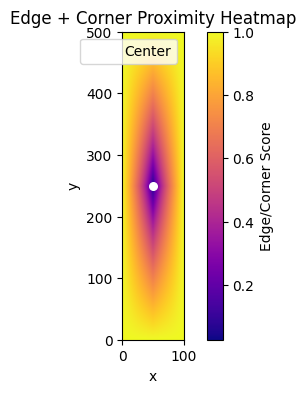

In [87]:
import torch
import matplotlib.pyplot as plt

def edge_corner_score(x, y, x_c, y_c, w, h, gamma=1.0):
    dx = 2 * torch.abs(x - x_c) / w
    dy = 2 * torch.abs(y - y_c) / h
    dx = torch.clamp(dx, 0, 1)
    dy = torch.clamp(dy, 0, 1)
    score = (dx + dy - dx * dy) ** gamma
    return score

# Rectangle parameters
w, h = 100, 500
x_c, y_c = w / 2, h / 2

# Create grid of coordinates
x = torch.linspace(0, w, 400)
y = torch.linspace(0, h, 300)
xx, yy = torch.meshgrid(x, y, indexing="xy")

# Compute edge/corner score over the grid
score_map = edge_corner_score(xx, yy, x_c, y_c, w, h, gamma=0.7)

# Plot the heatmap
plt.figure(figsize=(6,4))
plt.imshow(score_map.numpy(), origin="lower", cmap="plasma", extent=[0, w, 0, h])
plt.colorbar(label="Edge/Corner Score")
plt.title("Edge + Corner Proximity Heatmap")
plt.xlabel("x")
plt.ylabel("y")
plt.scatter([x_c], [y_c], c="white", s=30, label="Center")
plt.legend()
plt.show()


In [70]:

def edge_corner_score(x, y, x_c, y_c, w, h, gamma=0.7):
    dx = 2 * torch.abs(x - x_c) / w
    dy = 2 * torch.abs(y - y_c) / h
    dx = torch.clamp(dx, 0, 1)
    dy = torch.clamp(dy, 0, 1)
    # high on edges + corners, low at center
    score = (dx + dy - dx * dy) ** gamma
    return score


In [257]:
import torch
import torch.nn.functional as F
import numpy as np

def adjust_bbox_by_gradient(prob_map, bbox, max_iter=50, step=1, gain_thresh=0.001, device='cpu'):
    """
    Expands or shifts a bounding box toward the segmentation region
    guided by gradients in the probability map.
    """
    if isinstance(prob_map, np.ndarray):
        prob_map = torch.from_numpy(prob_map)
    prob_map = prob_map.float().to(device)
    H, W = prob_map.shape

    bbox = torch.tensor(bbox, dtype=torch.float32, device=device)

    # Compute gradients once
    gy, gx = torch.gradient(prob_map)
    grad_mag = torch.sqrt(gx**2 + gy**2)

    def clamp_box(b):
        x1, y1, x2, y2 = b
        return torch.tensor([
            torch.clamp(x1, 0, W-1),
            torch.clamp(y1, 0, H-1),
            torch.clamp(x2, 1, W),
            torch.clamp(y2, 1, H)
        ], device=device)

    for i in range(max_iter):
        x1, y1, x2, y2 = bbox.int()
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(W-1, x2), min(H-1, y2)
        if x2 <= x1 or y2 <= y1:
            break

        # Measure edge gradient means
        top_grad = grad_mag[y1, x1:x2].mean()
        bottom_grad = grad_mag[y2-1, x1:x2].mean()
        left_grad = grad_mag[y1:y2, x1].mean()
        right_grad = grad_mag[y1:y2, x2-1].mean()

        edges = {
            'up': top_grad,
            'down': bottom_grad,
            'left': left_grad,
            'right': right_grad
        }

        best_edge = max(edges, key=edges.get)
        best_grad = edges[best_edge].item()

        if best_grad < gain_thresh:
            break

        # Move or expand the chosen edge outward
        if best_edge == 'up':
            bbox[1] -= step
        elif best_edge == 'down':
            bbox[3] += step
        elif best_edge == 'left':
            bbox[0] -= step
        elif best_edge == 'right':
            bbox[2] += step

        bbox = clamp_box(bbox)

    # Final mask
    final_mask = torch.zeros_like(prob_map)
    x1, y1, x2, y2 = bbox.int()
    final_mask[y1:y2, x1:x2] = 1.0

    return bbox.cpu().tolist(), final_mask.cpu()


In [258]:
import os
import torch
import numpy as np
import torchvision
import os
import cv2

save_dir = "entropy_sorted"
os.makedirs(save_dir, exist_ok=True)

W, H = 1024, 1024

for rank, (entropy_scalar, img_path, render) in enumerate(collected, start=1):
    img_name = os.path.splitext(os.path.basename(img_path))[0]

    # ---- Convert and move to device
    img_np = render['real']        # numpy HxWx3
    img_tensor = torch.from_numpy(img_np).permute(2,0,1).float() / 255.0
    img_tensor = img_tensor.unsqueeze(0).to(fabric.device)

    prompt_main = render['prompt']
    # ---- Forward pass to get entropy + predictions
    # entropy_maps, preds = process_forward(img_tensor, prompt_main)

    # print(prompt_main[0][0].shape)
    # pred_stack = torch.stack(preds, dim=0)

    # # Convert to binary masks (e.g., threshold 0.99 as you do)
    # pred_binary = (pred_stack > 0.99).float() 
    # # Count overlaps
    # overlap_count = pred_binary.sum(dim=0)  # (1,1024,1024)
    
    # # Optional: extract overlapping region mask (for debugging)
    # overlap_map = (overlap_count > 1).float()
    # invert_overlap_map = 1.0 - overlap_map
    
    # # Convert to uint8 for visualization/saving
    # # non_overlap_vis = (non_overlap_map[0].cpu().numpy() * 255).astype(np.uint8)
    

    # # # ---- Save the original image once
    img_save_path = os.path.join(save_dir, f"{rank}.jpg")
    cv2.imwrite(img_save_path, cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))

    # scores = []
    # # ---- Loop over instances (each mask + entropy)
    # for i, (entr_map, pred) in enumerate(zip(entropy_maps, preds)):
    #     # # Normalize entropy 0–1
    #     # entr_norm = (entr_map - entr_map.min()) / (entr_map.max() - entr_map.min() + 1e-8)

    #     # # Convert to uint8
    #     # entr_vis = (entr_norm[0].cpu().numpy() * 255).astype(np.uint8)
    #     pred = (pred[0]>0.99) 
    #     pred_w_overlap = pred * invert_overlap_map[0]

        

        
    #     # Find where mask == 1
    #     ys, xs = torch.where(pred_w_overlap > 0.5)
    #     if len(xs) > 0 and len(ys) > 0:
    #         x_min, x_max = xs.min().item(), xs.max().item()
    #         y_min, y_max = ys.min().item(), ys.max().item()
    #         h, w = y_max - y_min, x_max - x_min
    #         print(f"Bounding box: ({x_min}, {y_min}) → ({x_max}, {y_max})") 
    #         cx = (x_min + x_max) / 2.0
    #         cy = (y_min + y_max) / 2.0
    #         # # Optional: draw rectangle
    #         # mask_vis = (pred_w_overlap.cpu().numpy() * 255).astype(np.uint8)
    #         # mask_rgb = cv2.cvtColor(mask_vis, cv2.COLOR_GRAY2BGR)
    #         # cv2.rectangle(mask_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    #         # pred_path = os.path.join(save_dir, f"{rank:04d}_{img_name}_{i}mask_with_box.png")
    #         # cv2.imwrite(pred_path, mask_rgb)
    #     else:
    #         print("No 1s found in mask")
    #     # Make sure both tensors are on same device
    #     point_ref = torch.tensor([cx, cy], dtype=torch.float32, device=prompt_main[0][0][i].device)
    #     score = edge_corner_score(prompt_main[0][0][i][0][0].item(), prompt_main[0][0][i][0][1].item(), point_ref[0], point_ref[1], w, h)
    #     scores.append(score)
    #     # point_ref = torch.tensor([cx, cy], dtype=torch.float32, device=prompt_main[0][0][i].device)
    #     # dist = torch.dist(prompt_main[0][0][i], point_ref)
        
    #     # pred_w_overlap_vis = (pred_w_overlap.cpu().numpy()* 255).astype(np.uint8)
    

    #     # # Save prediction mask
    #     # pred_path = os.path.join(save_dir, f"{rank:04d}_{img_name}_{i}_pred.png")
    #     # cv2.imwrite(pred_path, pred_w_overlap_vis)
    # print(f"Saved image + {len(entropy_maps)} instance maps for {img_name}")


    x_offset = 16
    y_offset = 16
    refine_iter = 20
    for refine in range(refine_iter):

        if refine == 0:
            bboxes = []
            for j in range(len(prompt_main[0][0])):
                x = prompt_main[0][0][j][0][0]
                y = prompt_main[0][0][j][0][1]
    
                bboxes.append(torch.tensor([x-x_offset, y - y_offset, x + x_offset, y + y_offset], dtype=torch.float32))

            bboxes = torch.stack(bboxes)
        with torch.no_grad():
            _, masks_pred, _, _ = model(img_tensor, bboxes.unsqueeze(0))

        # masks_pred[0] shape -> [num_boxes, H, W]
        pred_masks = masks_pred[0].cpu()  
        bbox_new = []
        for i, mask in enumerate(pred_masks):
            # Threshold mask to binary: 0 or 255
            mask_bin = (mask > 0.5).numpy().astype(np.uint8) * 255  # clean mask
            
            
            
            
            
            # -------------------------
            # Compute and save entropy heatmap
            # -------------------------
            # Convert mask to probability (0-1)
            mask_prob = mask.numpy()
            
            # Avoid log(0) by clamping probabilities
            eps = 1e-6
            mask_prob = np.clip(mask_prob, eps, 1 - eps)
            # Compute entropy per pixel
            entropy_map = - (mask_prob * np.log(mask_prob) + (1 - mask_prob) * np.log(1 - mask_prob))
            
            # Normalize entropy to 0-255 for visualization
            entropy_norm = ((entropy_map - entropy_map.min()) / (entropy_map.max() - entropy_map.min()) * 255).astype(np.uint8)
            
            # Crop the entropy map to the bounding box
            entropy_roi = entropy_map[y1:y2, x1:x2]
            
            # Compute mean entropy inside the rectangle
            mean_entropy = entropy_roi.mean()
            
            print(f"Mask {i} mean entropy inside bbox: {mean_entropy:.4f}")
                    

      
            prob_map = mask.numpy()
            opt_box, _ = adjust_bbox_by_gradient(prob_map, bboxes[i].int().tolist())
            opt_box = list(map(int, opt_box))
          
            bbox_new.append(torch.tensor(opt_box, dtype=torch.float32))

            


            

            
            if refine == (refine_iter-1):
                
                # Convert to 3-channel for colored box
                mask_color = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
                
                # Draw bounding box
                x1, y1, x2, y2 = bboxes[i].int().tolist()
                cv2.rectangle(mask_color, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=2)
    
                # Apply a colormap for better visualization
                entropy_color = cv2.applyColorMap(entropy_norm, cv2.COLORMAP_JET)
                # Draw bounding box on entropy map as well
                cv2.rectangle(entropy_color, (x1, y1), (x2, y2), color=(255, 255, 255), thickness=2)
                
                # Save entropy heatmap
                save_path_entropy = os.path.join(save_dir, f"{rank}_{i}_entropy_heatmap.png")
                cv2.imwrite(save_path_entropy, entropy_color)
                print(f"Saved {save_path_entropy}")
    
                # Draw bounding box
                x1, y1, x2, y2 = opt_box
                cv2.rectangle(mask_color, (x1, y1), (x2, y2), color=(0, 255, 255), thickness=2)
                
                
    
                # Save the clean mask with box
                save_path = os.path.join(save_dir, f"{rank}_{i}_mask_clean_box.png")
                cv2.imwrite(save_path, mask_color)
                print(f"Saved {save_path}")
        
        bbox_new = torch.stack(bbox_new)
        bboxes = bbox_new
     

        
    

    # Stop early for testing
    if rank >= 5:
        break


Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0012
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0018
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0033
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0094
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0076
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0313
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0117
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0180
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0386
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0698
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0168
Mask 0 mean entropy inside bbox: 0.0000
Mask 1 mean entropy inside bbox: 0.0145
Mask 0 mean entropy inside bbox: 0.0000
